In [1]:
import sys
sys.path.append('..')
from bast.tools import incident, compute_currents, nanometers
from bast.matrices import matrix_s, multS
from bast.lattice import CartesianLattice
import numpy as np
from math import prod
import scipy

pw=(2, 2)
nx, ny = pw[0] // 2, pw[1] // 2
a  = nanometers(100)
lattice = CartesianLattice(pw, a1=(a/2, 0.0), a2=(0.0, a/2), eps_emerg=1.0)
N = 70
wavelengths = 1 / np.linspace(1./nanometers(10000), 1./nanometers(100), N)
theta = 0
phi = 0

In [6]:
from bast.scattering import scattering_matrix,scattering_matrix_npy
from tqdm import tqdm

spectrum = []
scatmats = []
truets = []
for i, wavelength in enumerate(tqdm(wavelengths)):
    kp = lattice.kp_angle(wavelength, theta, phi)
    kp = (0, 2 * np.pi / a/2)
    U, Vi = lattice.U(wavelength, kp), lattice.Vi(wavelength, kp)
    Ve = lattice.Ve(wavelength, kp)
    S0, bf = scattering_matrix(pw, lattice, "rectangle", [0, 0, a,a], island_eps=13.0, eps_host=13.0, wavelength=wavelength, depth=0.5*a, slicing_pow=2, kp=kp)
    S1, bf = scattering_matrix(pw, lattice, "rectangle", [0, 0, a,a], island_eps=1.0, eps_host=1.0, wavelength=wavelength, depth=0.5*a, slicing_pow=2, kp=kp)
    S = multS(S0, S1)
    
    scatmats.append(S.copy())

    

100%|███████████████████████████████████████████████| 70/70 [00:00<00:00, 128.46it/s]


100%|███████████████████████████████████████████████| 70/70 [00:00<00:00, 659.50it/s]


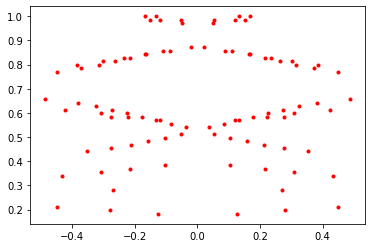

In [7]:
from bast.eigentricks import scattering_splitlr

import matplotlib.pyplot as plt
for S, wl in zip(tqdm(scatmats), wavelengths):
    Sl, Sr = scattering_splitlr(S)
    w, v = scipy.linalg.eig(Sl, Sr)
    mask = np.abs(np.abs(w) - 1.0) < 1e-10
    #plt.plot(np.angle(w[mask]), a/np.ones(w[mask].shape[0]) / wl, 'r.')    
    plt.plot(np.angle(w[mask])/2/np.pi, a/(np.ones(w[mask].shape[0])*wl), 'r.')

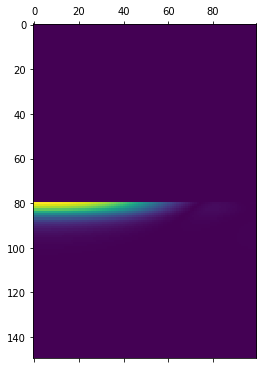

In [42]:
from bast.eigentricks import scattering_splitlr
import matplotlib.pyplot as plt
detP = np.zeros((150, 100), dtype=np.complex128)
for i, (S, wl) in enumerate(zip(scatmats, wavelengths)):
    Sl, Sr = scattering_splitlr(S)
    
    for j, kz in enumerate(np.linspace(0, np.pi, 100)):
        kx = 0.0
        ky = 0.0
        P = Sl - np.exp(1j*kz) * Sr
        detP[i, j] = np.linalg.det(P)
        
plt.matshow(np.log1p(np.flipud(np.abs(detP))))